In [3]:
import re
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import datetime as dt

from sklearn import model_selection

from sklearn.metrics import confusion_matrix

%matplotlib inline 

### Global variables

In [4]:
random_state = 100
n_jobs = 6
#n_jobs = 2
cv = 5
scoring = 'neg_mean_absolute_error'

### Load data

In [5]:
train_df = pd.read_csv('./house-prices-advanced-regression-techniques/train.csv')
print('Train data shape: ', train_df.shape)

test_df = pd.read_csv('./house-prices-advanced-regression-techniques/test.csv')
print('Test data shape: ', test_df.shape)

Train data shape:  (1460, 81)
Test data shape:  (1459, 80)


In [6]:
y_train = train_df['SalePrice']

train_df.drop(['SalePrice'], axis=1, inplace=True)

train_df.shape

(1460, 80)

In [7]:
all_df = pd.concat([train_df, test_df])

all_df.shape

(2919, 80)

### Handle columns with nulls

In [8]:
train_df.isnull().sum()[train_df.isnull().sum() > 0]

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [9]:
test_df.isnull().sum()[test_df.isnull().sum() > 0]

MSZoning           4
LotFrontage      227
Alley           1352
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        16
MasVnrArea        15
BsmtQual          44
BsmtCond          45
BsmtExposure      44
BsmtFinType1      42
BsmtFinSF1         1
BsmtFinType2      42
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu      730
GarageType        76
GarageYrBlt       78
GarageFinish      78
GarageCars         1
GarageArea         1
GarageQual        78
GarageCond        78
PoolQC          1456
Fence           1169
MiscFeature     1408
SaleType           1
dtype: int64

In [10]:
# numeric features

numeric_features_fill_mean = [ 'LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
                             'TotalBsmtSF', 'GarageArea']

for feature in numeric_features_fill_mean:
    all_df[feature]=all_df[feature].fillna(all_df[feature].mean())

In [11]:
numeric_features_fill_mode = ['GarageYrBlt', 'BsmtFullBath', 'BsmtHalfBath', 'GarageCars']

for feature in numeric_features_fill_mode:
    all_df[feature]=all_df[feature].fillna(all_df[feature].mode()[0])

In [12]:
# categorical features

categorical_features_fill_none = ['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
                                 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageType',
                                 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
                                  'MiscFeature']

for feature in categorical_features_fill_none:
    all_df[feature]=all_df[feature].fillna('None')

In [13]:
categorical_features_fill_mode = ['Electrical', 'MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd',
                                 'KitchenQual', 'Functional', 'SaleType']

for feature in categorical_features_fill_mode:
    all_df[feature]=all_df[feature].fillna(all_df[feature].mode()[0])

In [14]:
test_id = test_df['Id']

train_df.drop(['Id'],axis=1,inplace=True)
test_df.drop(['Id'],axis=1,inplace=True)
all_df.drop(['Id'],axis=1,inplace=True)

In [15]:
print('Train data shape: ', train_df.shape)
print('Test data shape: ', test_df.shape)
print('All df data shape: ', all_df.shape)

Train data shape:  (1460, 79)
Test data shape:  (1459, 79)
All df data shape:  (2919, 79)


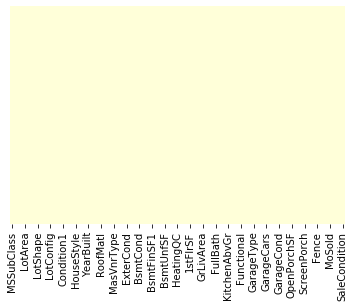

In [16]:
sns.heatmap(all_df.isnull(), yticklabels=False, cbar=False, cmap='YlGnBu')

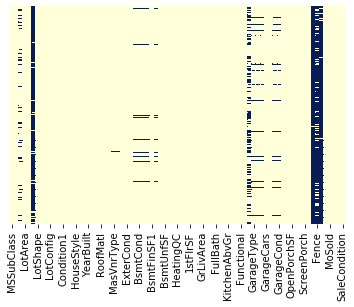

In [17]:
sns.heatmap(train_df.isnull(), yticklabels=False, cbar=False, cmap='YlGnBu')

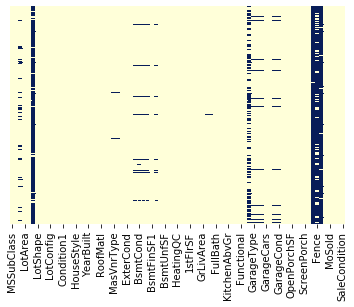

In [18]:
sns.heatmap(test_df.isnull(), yticklabels=False, cbar=False, cmap='YlGnBu')

### Dummify categorical features

In [19]:
all_df = pd.get_dummies(all_df)

all_df.shape

(2919, 302)

In [20]:
colsToBeDummified = pd.Series(
    ['MSSubClass',
    'OverallQual',
    'OverallCond'])

for col in colsToBeDummified:
    dummies = pd.get_dummies(all_df[col], drop_first=True, prefix=col)
    all_df[dummies.columns] = dummies
    
all_df.drop(colsToBeDummified, axis=1, inplace=True)

In [21]:
all_df.shape

(2919, 331)

### Feature selection and reduction

In [74]:
from sklearn.datasets import make_regression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

fs = SelectKBest(score_func=f_regression, k=10)

x_train = all_df.iloc[:train_df.shape[0],:]

X_selected = fs.fit_transform(x_train, y_train)

mask = fs.get_support()

/Users/kmanda/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


In [75]:
selected_features = []

for bool, feature in zip(mask, all_df.columns):
    if bool:
        selected_features.append(feature)        

selected_features_df = pd.DataFrame(all_df[selected_features])

selected_features_df.columns

Index(['YearBuilt', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'FullBath',
       'TotRmsAbvGrd', 'GarageCars', 'GarageArea', 'ExterQual_TA',
       'BsmtQual_Ex'],
      dtype='object')

### EDA

Text(0.5, 0, 'Sale Price')

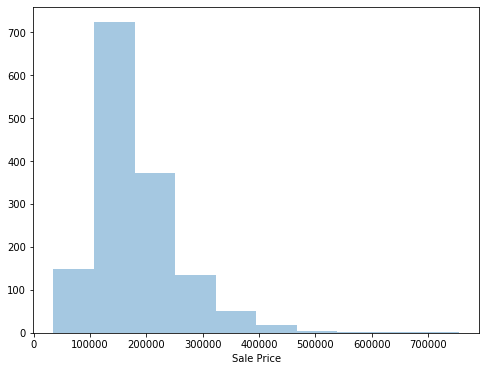

In [83]:
# SalePrice - Sale Price

fig, ax = plt.subplots(figsize=(6, 6))
sns.distplot(y_train, norm_hist=False, kde=False, bins=10)

ax.set_xlabel('Sale Price')

Text(0.5, 0, 'Sale Price')

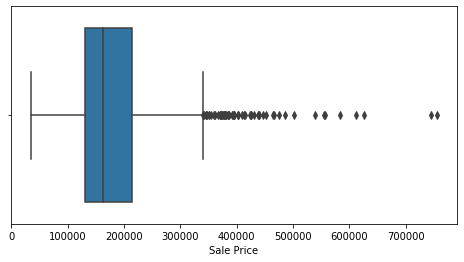

In [87]:
# SalePrice - Sale Price

fig, ax = plt.subplots(figsize=(8, 4))
sns.boxplot(y_train, ax=ax)

ax.set_xlabel('Sale Price')

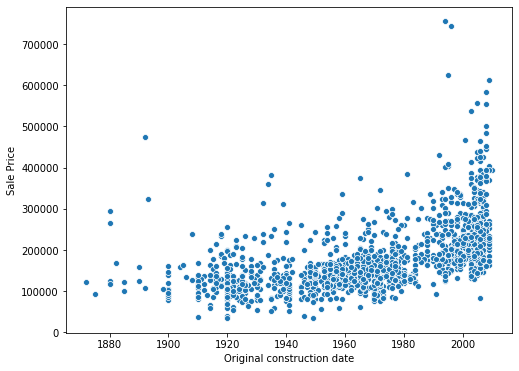

In [70]:
# YearBuilt - Original construction date

fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(train_df['YearBuilt'], y_train, ax=ax, marker='o')

ax.set_xlabel('Original construction date')
ax.set_ylabel('Sale Price')

plt.show()

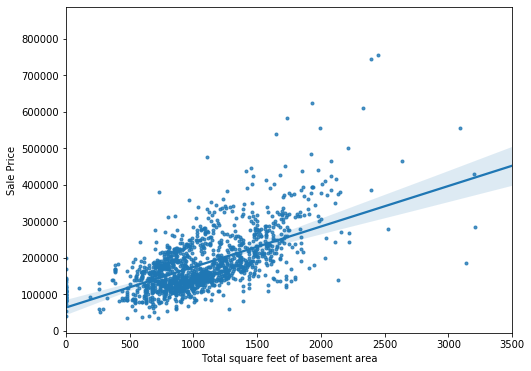

In [64]:
# TotalBsmtSF - Total square feet of basement area

fig, ax = plt.subplots(figsize=(8, 6))
sns.regplot(train_df['TotalBsmtSF'], y_train, ax=ax, marker='.')

ax.set(xlim=(0, 3500))
ax.set_xlabel('Total square feet of basement area')
ax.set_ylabel('Sale Price')

plt.show()

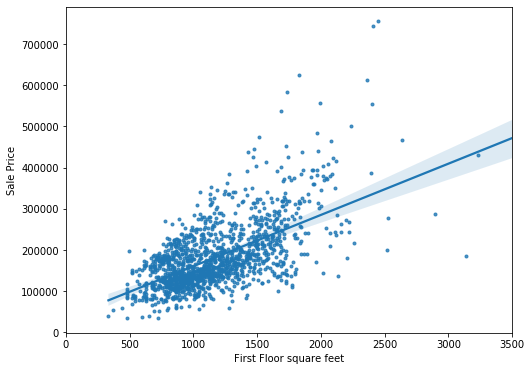

In [65]:
# 1stFlrSF - First Floor square feet

fig, ax = plt.subplots(figsize=(8, 6))
sns.regplot(train_df['1stFlrSF'], y_train, ax=ax, marker='.')

ax.set(xlim=(0, 3500))
ax.set_xlabel('First Floor square feet')
ax.set_ylabel('Sale Price')

plt.show()

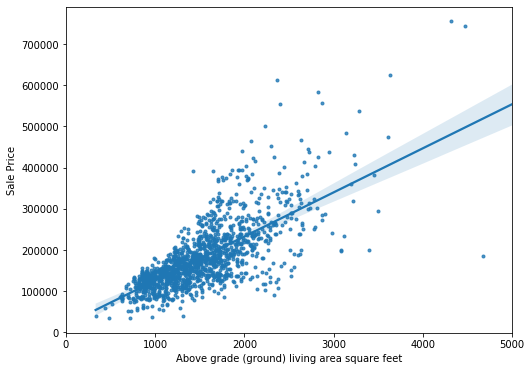

In [67]:
# GrLivArea - Above grade (ground) living area square feet

fig, ax = plt.subplots(figsize=(8, 6))
sns.regplot(train_df['GrLivArea'], y_train, ax=ax, marker='.')

ax.set(xlim=(0, 5000))
ax.set_xlabel('Above grade (ground) living area square feet')
ax.set_ylabel('Sale Price')

plt.show()

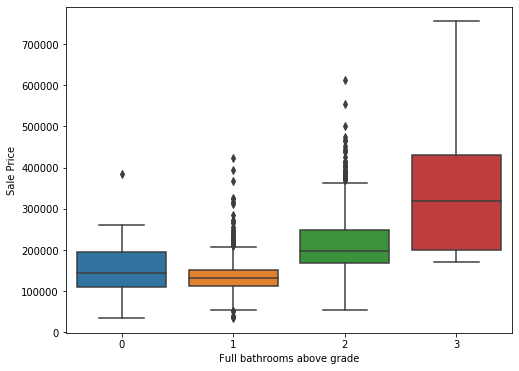

In [51]:
# FullBath - Full bathrooms above grade

fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(train_df['FullBath'], y_train, ax=ax)

ax.set_xlabel('Full bathrooms above grade')
ax.set_ylabel('Sale Price')

plt.show()

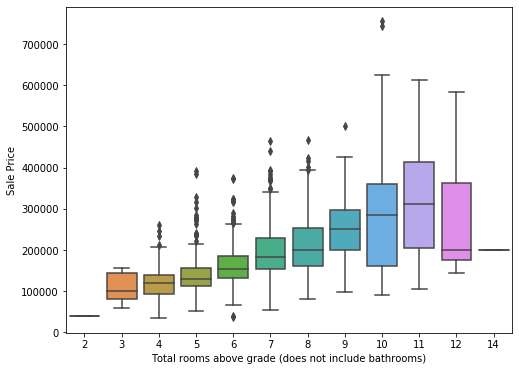

In [52]:
# TotRmsAbvGrd - Total rooms above grade (does not include bathrooms)

fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(train_df['TotRmsAbvGrd'], y_train, ax=ax)

ax.set_xlabel('Total rooms above grade (does not include bathrooms)')
ax.set_ylabel('Sale Price')

plt.show()

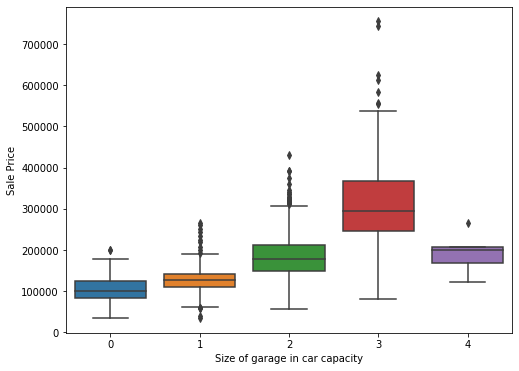

In [53]:
# GarageCars - Size of garage in car capacity

fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(train_df['GarageCars'], y_train, ax=ax)

ax.set_xlabel('Size of garage in car capacity')
ax.set_ylabel('Sale Price')

plt.show()

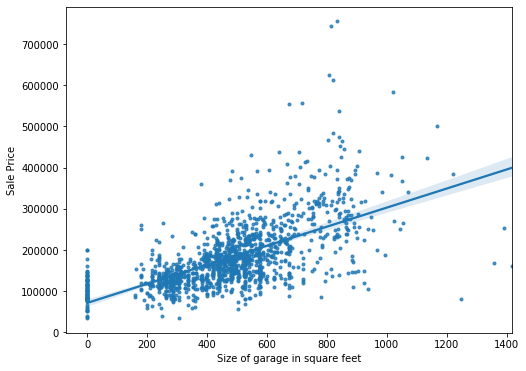

In [71]:
# GarageArea - Size of garage in square feet

fig, ax = plt.subplots(figsize=(8, 6))
sns.regplot(train_df['GarageArea'], y_train, ax=ax, marker='.')

ax.set_xlabel('Size of garage in square feet')
ax.set_ylabel('Sale Price')

plt.show()

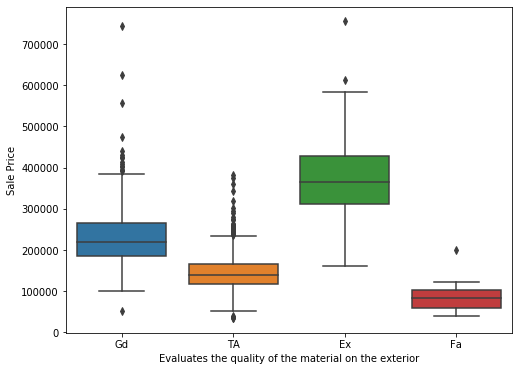

In [55]:
# ExterQual - Evaluates the quality of the material on the exterior

fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(train_df['ExterQual'], y_train, ax=ax)

ax.set_xlabel('Evaluates the quality of the material on the exterior')
ax.set_ylabel('Sale Price')

plt.show()

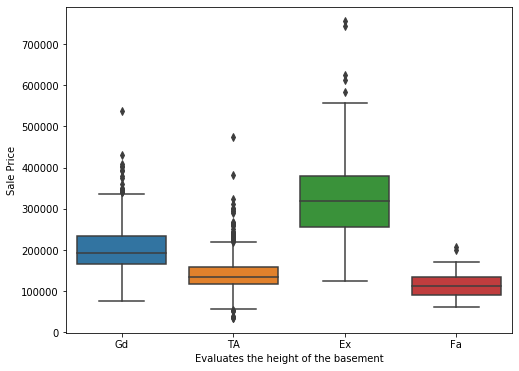

In [56]:
# BsmtQual - Evaluates the height of the basement

fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(train_df['BsmtQual'], y_train, ax=ax)

ax.set_xlabel('Evaluates the height of the basement')
ax.set_ylabel('Sale Price')

plt.show()

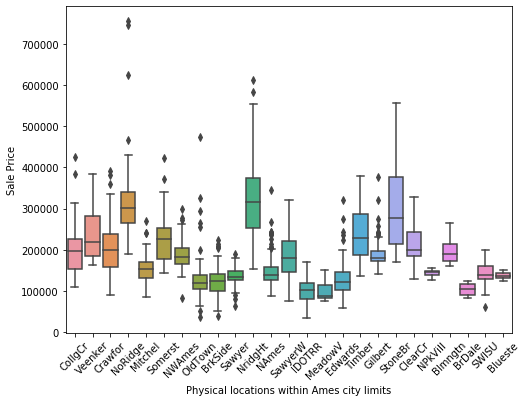

In [90]:
# Neighborhood - Physical locations within Ames city limits

fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(train_df['Neighborhood'], y_train, ax=ax)

ax.set_xlabel('Physical locations within Ames city limits')
ax.set_ylabel('Sale Price')
plt.xticks(rotation=45)

plt.show()